In [ ]:

from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, Flatten,Dense, Dropout, Activation
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from google.colab import drive

In [ ]:

drive.mount('/content/drive')

traindata_path = '/content/drive/MyDrive/ddos/KDDTrain+.txt'
testdata_path = '/content/drive/MyDrive/ddos/KDDTest+.txt'

col_names = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent'
            ,'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root'
            ,'num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login'
            ,'is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate'
            ,'same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
            ,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate'
            ,'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate'
            ,'dst_host_srv_rerror_rate','attack','outcome']

# Read CSV files using Pandas
traindata = pd.read_csv(traindata_path, header=None, names = col_names)
testdata = pd.read_csv(testdata_path, header=None, names = col_names)

Mounted at /content/drive


In [ ]:

for i in ['protocol_type',"service","flag"]:
    traindata[i] = traindata[i].astype('category').cat.codes
    testdata[i] = testdata[i].astype('category').cat.codes

In [ ]:

def lab(traindata):

    classlist = []

    check1 = ("apache2","back","land","neptune","mailbomb","pod","processtable","smurf","teardrop","udpstorm","worm")
    check2 = ("ipsweep","mscan","nmap","portsweep","saint","satan")
    check3 = ("buffer_overflow","loadmodule","perl","ps","rootkit","sqlattack","xterm")
    check4 = ("ftp_write","guess_passwd","httptunnel","imap","multihop","named","phf","sendmail","Snmpgetattack","spy","snmpguess","warezclient","warezmaster","xlock","xsnoop")


    for item in traindata.pop('attack'):
        if item in check1:
            classlist.append("DoS")
        elif item in check2:
            classlist.append("Probe")
        elif item in check3:
            classlist.append("U2R")
        elif item in check4:
            classlist.append("R2L")
        else:
            classlist.append("ANormal")

    return classlist

y_train_original = np.array(lab(traindata))
y_test_original = np.array(lab(testdata))

In [ ]:
def normalize(df, cols):
    result = df.copy() # do not touch the original df
    for feature_name in cols:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        if max_value > min_value:
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result


In [ ]:
trainX = pd.DataFrame(normalize(traindata,traindata.columns))
trainT = pd.DataFrame(normalize(testdata,testdata.columns))

In [ ]:
unique_values, counts = np.unique(y_train_original, return_counts=True)

# Print the unique values and their counts
print("Unique Classes:", unique_values)
print("Counts:", counts)

Unique Classes: ['ANormal' 'DoS' 'Probe' 'R2L' 'U2R']
Counts: [67343 45927 11656   995    52]


In [ ]:

le = LabelEncoder()
y_train = le.fit_transform(y_train_original)
y_test = le.transform(y_test_original)

In [ ]:


# Calculate class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_original), y=y_train_original)  # Ensure y_train_original is your original labels before one-hot encoding
class_weight_dict = dict(enumerate(class_weights))

# Prepare data: Convert integer labels to one-hot
y_train = to_categorical(y_train, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Build the CNN model
cnn = Sequential()
cnn.add(Convolution1D(64, 3, padding="same", activation="relu", input_shape=(42, 1)))
cnn.add(Convolution1D(64, 3, padding="same", activation="relu"))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(Convolution1D(128, 3, padding="same", activation="relu"))
cnn.add(MaxPooling1D(pool_size=(2)))
cnn.add(Flatten())
cnn.add(Dense(128, activation="relu"))
cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation="softmax"))

# Compile the model
cnn.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])


# Train the model with class weights
cnn.fit(trainX, y_train, epochs=10, validation_data=(trainT, y_test))



Epoch 1/10
3937/3937 [==============================] - 90s 22ms/step - loss: 0.0480 - accuracy: 0.9848 - val_loss: 1.5132 - val_accuracy: 0.7937
Epoch 2/10
3937/3937 [==============================] - 83s 21ms/step - loss: 0.0171 - accuracy: 0.9945 - val_loss: 1.5544 - val_accuracy: 0.7736
Epoch 3/10
3937/3937 [==============================] - 83s 21ms/step - loss: 0.0134 - accuracy: 0.9957 - val_loss: 2.0957 - val_accuracy: 0.7793
Epoch 4/10
3937/3937 [==============================] - 82s 21ms/step - loss: 0.0110 - accuracy: 0.9965 - val_loss: 1.4999 - val_accuracy: 0.7969
Epoch 5/10
3937/3937 [==============================] - 82s 21ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 1.9723 - val_accuracy: 0.7803
Epoch 6/10
3937/3937 [==============================] - 83s 21ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 2.5580 - val_accuracy: 0.7691
Epoch 7/10
3937/3937 [==============================] - 82s 21ms/step - loss: 0.0080 - accuracy: 0.9974 - val_loss: 2.1250 -

In [ ]:
class_names = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

In [ ]:
# Make predictions
predictions = cnn.predict(trainT)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


705/705 [==============================] - 5s 7ms/step


In [ ]:

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Generate a classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80      9889
         DoS       0.93      0.77      0.84      7460
       Probe       0.72      0.53      0.61      2421
         R2L       0.94      0.15      0.26      2707
         U2R       0.30      0.42      0.35        67

    accuracy                           0.76     22544
   macro avg       0.71      0.57      0.57     22544
weighted avg       0.80      0.76      0.73     22544



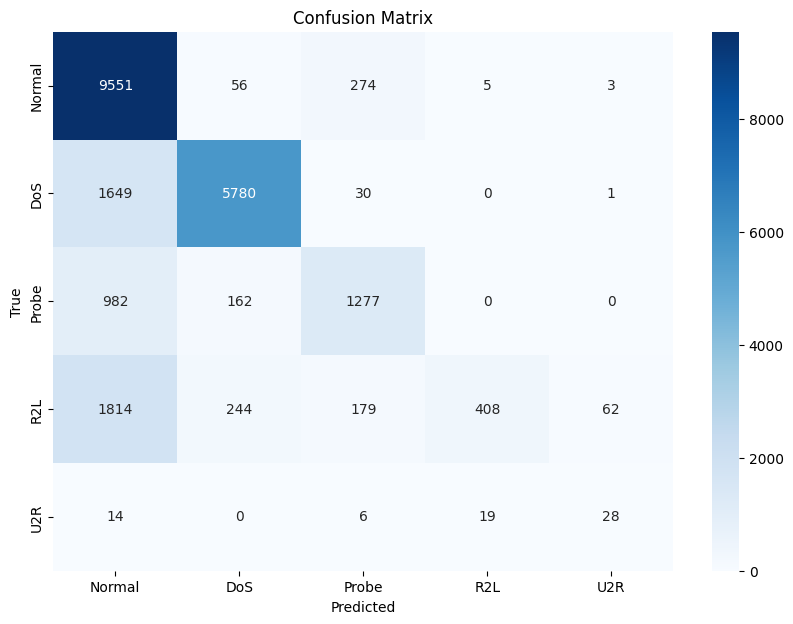

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
